In [20]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [21]:
del train_images, train_labels

In [22]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

In [23]:
dpe = DPE('COM6')

Running <function DPE.init_dut at 0x0E522588> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected


In [24]:
dpe.set_clock(50)

Running <function DPE.set_clock at 0x0E522618> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [25]:
g = dpe.read(1) 

Running <function DPE.read at 0x0E5226A8> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


Text(0.5, 1.0, 'Conductance (uS)')

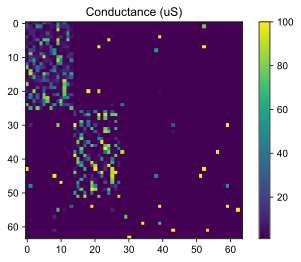

In [26]:
plt.imshow(g * 1e6)
plt.clim(1, 100)
plt.colorbar()
plt.title('Conductance (uS)')

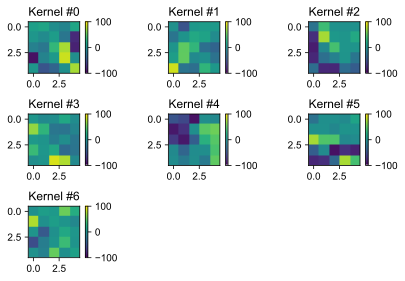

In [27]:
g_sel = g[:25, :14] * 1e6
g_sel = g_sel[:,::2] - g_sel[:,1::2] 

for i in range(7):
    plt.subplot('33' + str(i+1))
    plt.title('Kernel #' + str(i))
    plt.imshow(g_sel[:,i].reshape(5,5))
    plt.clim(-100, 100)
    plt.colorbar()
plt.tight_layout()

In [28]:
nn = NN_dpe(weights)

In [28]:
img_idx = 0

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [33]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) 

Running <function DPE.multiply at 0x0E9578E8> with serial
[INFO] Elapsed time = 1.52s
Serial disconnected


In [34]:
outputs.shape

(400, 14)

In [35]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

In [ ]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

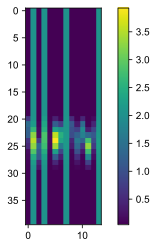

In [37]:
plt.imshow(software[:40])
plt.colorbar()

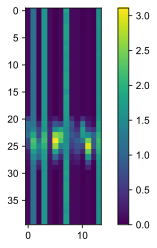

In [38]:
plt.imshow(outputs[:40])
plt.colorbar()

In [39]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 1.28888049,  0.02398606],
       [ 1.05046865,  0.85570145],
       [ 1.24330265, -0.02982188],
       [ 1.50891986, -0.27118278],
       [ 1.26304519, -0.11854705],
       [ 1.08898811,  0.08057355],
       [ 1.15497187, -0.07372081],
       [ 1.47053466, -0.4377051 ],
       [ 1.19740407, -0.11153613],
       [ 1.41694676,  0.03520104],
       [ 1.2272016 ,  0.02062674],
       [ 1.12024684, -0.0319466 ],
       [ 1.1513523 ,  0.06746589],
       [ 0.84929991,  0.62288986]])

In [40]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

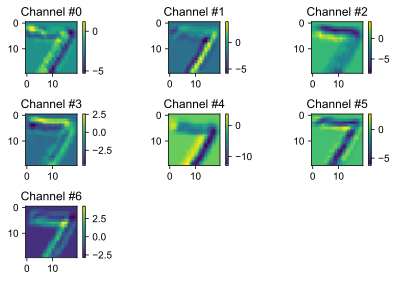

In [46]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
for i in range(7):
    plt.subplot('33' + str(i+1))
    plt.title('Channel #' + str(i))
    plt.imshow(x[:,:,i])
    plt.colorbar()
    
plt.tight_layout()

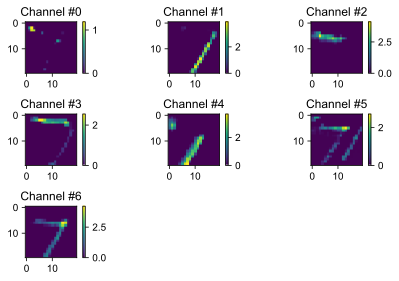

In [47]:
x1 = nn.relu(x)

plt.title('After ReLU nonlinear activation')
for i in range(7):
    plt.subplot('33' + str(i+1))
    plt.title('Channel #' + str(i))
    plt.imshow(x1[:,:,i])
    plt.colorbar()
    
plt.tight_layout()

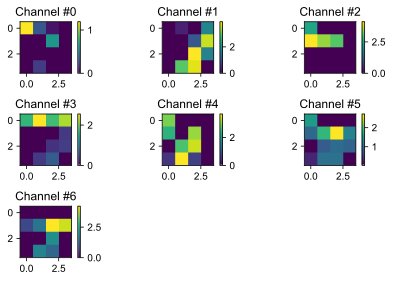

In [48]:
x2 = nn.max_pooling(x1)

plt.title('After ReLU nonlinear activation')
for i in range(7):
    plt.subplot('33' + str(i+1))
    plt.title('Channel #' + str(i))
    plt.imshow(x2[:,:,i])
    plt.colorbar()
    
plt.tight_layout()

In [32]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [49]:
load_workspace(vars(), '20190823-002528-prober2-reprogFC-delay-unary-64bit-95.33')

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, finalGfc, x2, sc1, sc2, Gfc1, Gfc2, output1, software1, output2, software2, lin_cor_fc1, lin_cor_fc2, output_corr, ys, batch_size, i, idx1, idx2, 


In [50]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9533

Text(0.5, 0, 'Digit #')

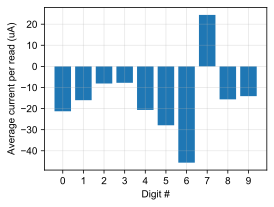

In [90]:
plt.figure(figsize=(4,3))
plt.bar(range(10), ys[0] * (sc1+sc2)/2 * 0.2 / 64 * 1e6) 
plt.grid(True, alpha=0.3)
_ = plt.xticks(range(10))

plt.ylabel('Average current per read (uA)')
plt.xlabel('Digit #')

Text(0, 0.5, 'Cumulative accuracy (%)')

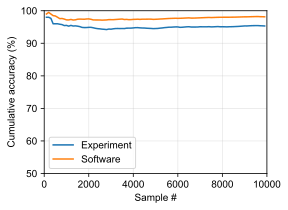

In [91]:
idx_list = np.arange(100, 10000, 100)
acc_list = []
acc_list_software = []

for i in idx_list:
    acc = ys[:i].argmax(axis=1) == test_labels[:i]
    acc_list.append(np.mean(acc))
    acc_list_software.append(np.mean(acc_software[:i]))
    
acc_list = np.array(acc_list)
acc_list_software = np.array(acc_list_software)
    
plt.figure(figsize=(4,3))
plt.plot(idx_list, acc_list * 100, label='Experiment')
plt.plot(idx_list, acc_list_software * 100, label='Software')
plt.legend()

plt.xlim(0, 10000)
plt.ylim(50, 100)
plt.grid(True, alpha=0.3)
plt.xlabel('Sample #')
plt.ylabel('Cumulative accuracy (%)')

In [77]:
acc_software = []

i = 0
xs = []

for label, img in zip(test_labels, test_images):
#     y = nn.forward_pass(img)
    
    vectors = nn._conv_flattern(img)
    x1 = nn.Gconv.T @ vectors / nn.Gratio
    x1 = x1[::2, :] - x1[1::2, :]
    x1 = x1.T.reshape(20,20,-1)
    
    x1 = nn.relu(x1)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
#     nn.Gconv.T @ vec_list[i]
    
    acc_software.append( y.argmax() == label)

    if (i+1)%100 == 0:
        display.clear_output(wait=True)
        print(f'i={i}, accuracy={np.mean(acc_software) * 100:.4f}%')
    i += 1

i=9999, accuracy=98.1500%


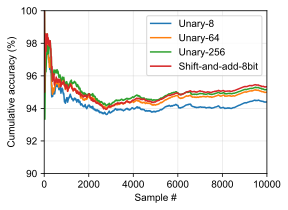

In [53]:
files = ['20190822-205109-prober2-reprogFC-delay-unary-8bit', 
         '20190822-213454-prober2-reprogFC-delay-unary-64bit-95', 
         '20190823-014700-prober2-reprogFC-delay-unary-256bit-95.16',
        '20190823-023051-prober2-reprogFC-delay-shift_add-8bit-95.33']

labels = ['Unary-8', 'Unary-64', 'Unary-256', 'Shift-and-add-8bit']


idx_list = np.arange(10, 10000, 10)

plt.figure(figsize=(4,3))
plt.xlim(0, 10000)
plt.ylim(90, 100)
plt.grid(True, alpha=0.3)
plt.xlabel('Sample #')
plt.ylabel('Cumulative accuracy (%)')

for lab, fn in zip(labels, files):
    acc_list = []
    
    data = load('data/' + fn)
    ys_i = data['ys']
    del data
    
    for i in idx_list:
        acc = ys_i[:i].argmax(axis=1) == test_labels[:i]
        acc_list.append(np.mean(acc))
        
    plt.plot(idx_list, np.array(acc_list) * 100, label=lab)

plt.legend()

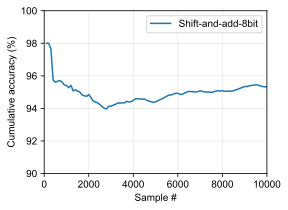

In [90]:
lab = labels[3]
fn = files[3]
acc_list = []
# 3.9 * 2 seconds per 1000 samples 

idx_list = np.arange(100, 10001, 100)

plt.figure(figsize=(4,3))
plt.xlim(0, 10000)
plt.ylim(90, 100)
plt.grid(True, alpha=0.3)
plt.xlabel('Sample #')
plt.ylabel('Cumulative accuracy (%)')

data = load('data/' + fn)
ys_i = data['ys']
del data

for i in idx_list:
    acc = ys_i[:i].argmax(axis=1) == test_labels[:i]
    acc_list.append(np.mean(acc))

plt.plot(idx_list, np.array(acc_list) * 100, label=lab)

plt.legend()

In [66]:
import time

In [ ]:
acc_list = np.array(acc_list)

# plt.figure(figsize=(4,3))
# plt.xlim(0, 10000)
# plt.ylim(90, 100)
# plt.grid(True, alpha=0.3)
# plt.xlabel('Sample #')
# plt.ylabel('Cumulative accuracy (%)')

for i in range( len(idx_list) ):
    
#     display.clear_output(wait=True)
    plt.cla()
    plt.xlim(0, 10000)
    plt.ylim(90, 100)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Sample #')
    plt.ylabel('Cumulative accuracy (%)')
    plt.plot(idx_list[:i], acc_list[:i]*100)
#     time.sleep(1)
    
#     display.display(fig)
    
    display.clear_output(wait = True)
    plt.pause(0.5)


# for i in idx_list:
#     acc = ys_i[:i].argmax(axis=1) == test_labels[:i]
#     acc_list.append(np.mean(acc))

# plt.plot(idx_list, np.array(acc_list) * 100, label=lab)

# plt.legend()

In [58]:
len(idx_list)

99

In [ ]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

In [29]:
load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [30]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [17]:
xs

array([[ 1.43760178, -0.        ,  2.6677077 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.40300978,  0.68757231,  2.79176243, ..., -0.        ,
         3.54113916,  2.61077068],
       [-0.        , -0.        ,  0.06726302, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.11108644, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.11126897, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.79958419, ..., -0.        ,
         3.2943451 ,  1.30286908]])

Read the conductance of the entire array

Running <function DPE.read at 0x0E5226A8> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


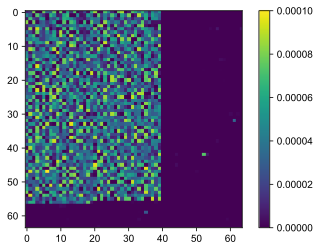

In [11]:
plt.imshow(dpe.read(2))
plt.clim(0, 100e-6)
plt.colorbar()

Running <function DPE.read at 0x0EB22660> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


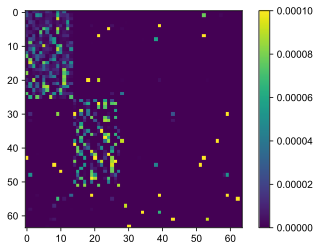

In [31]:
plt.imshow(dpe.read(1))
plt.clim(0, 100e-6)
plt.colorbar()

In [31]:
load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [32]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [33]:
dpe.N_BIT = 8

output1 = dpe.multiply(2, x1, c_sel=[0, 20], mode=0)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(2, x2, c_sel=[20, 40], mode=0)
software2 = (Gfc2.T @ x2).T 

Running <function DPE.multiply at 0x0E5228E8> with serial
[INFO] Elapsed time = 2.05s
Serial disconnected
Running <function DPE.multiply at 0x0E5228E8> with serial
[INFO] Elapsed time = 2.08s
Serial disconnected


In [112]:
# dpe.N_BIT = 8
# output1 = dpe.multiply_w_delay(2, x1, c_sel=[0, 20], mode=1, debug=True, delay=5)
# software1 = (Gfc1.T @ x1).T 

# output2 = dpe.multiply_w_delay(2, x2, c_sel=[20, 40], mode=1, debug=True, delay=5)
# software2 = (Gfc2.T @ x2).T 

In [34]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [35]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [36]:
# output_cor = lin_corr(output_sub, lin_cor_fc)

In [37]:
# for c in range(10):
#     x = software_sub[:,c]
#     y = output_cor[:,c]
    
#     plt.plot(x,y,'.')
#     plt.xticks(rotation=45)

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

In [38]:
outputs = dpe.multiply(0, x2, c_sel=[20, 40], mode=0) 
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Running <function DPE.multiply at 0x0E5228E8> with serial
[INFO] Elapsed time = 2.06s
Serial disconnected


In [39]:
# outputs = dpe.multiply_w_delay(2, x2, c_sel=[20, 40], mode=1, debug=True, delay=5)
output_corr = lin_corr(output2, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

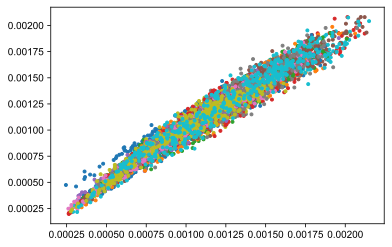

In [40]:
# lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
    plt.plot(x,y,'.')

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([  2.,   0.,   0.,   0.,   3.,   2.,   7.,   8.,   6.,  15.,  28.,
         21.,  40.,  47.,  63.,  84.,  87.,  91., 151., 193., 229., 244.,
        302., 376., 476., 562., 562., 579., 537., 488., 505., 444., 354.,
        296., 273., 235., 171., 139., 114.,  86.,  52.,  31.,  33.,  28.,
         21.,   5.,   3.,   2.,   3.,   2.]),
 array([-0.13118777, -0.12644627, -0.12170476, -0.11696325, -0.11222175,
        -0.10748024, -0.10273874, -0.09799723, -0.09325573, -0.08851422,
        -0.08377271, -0.07903121, -0.0742897 , -0.0695482 , -0.06480669,
        -0.06006518, -0.05532368, -0.05058217, -0.04584067, -0.04109916,
        -0.03635765, -0.03161615, -0.02687464, -0.02213314, -0.01739163,
        -0.01265012, -0.00790862, -0.00316711,  0.00157439,  0.0063159 ,
         0.01105741,  0.01579891,  0.02054042,  0.02528192,  0.03002343,
         0.03476494,  0.03950644,  0.04424795,  0.04898945,  0.05373096,
         0.05847247,  0.06321397,  0.06795548,  0.07269698,  0.07743849,
 

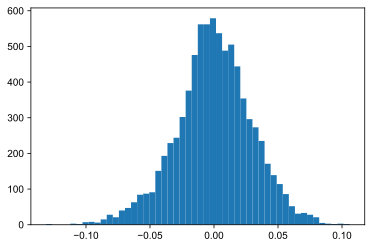

In [41]:
plt.hist((output_corr-software).reshape(-1, 1)/0.0025, bins=50 )

In [42]:
(output_corr-software).reshape(-1, 1).std()/0.00225

0.032947520832806394

In [43]:
# load_workspace(vars(), '20190821-051552-mnist_xs')
# xs = np.array(xs)

In [44]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20], mode=1)
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40], mode=1)
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Batch accuracy = 94.70%
Overall = 91.77%
Running on sample 6000-7000
Running <function DPE.multiply at 0x0E5228E8> with serial
[INFO] Elapsed time = 3.95s
Serial disconnected
Running <function DPE.multiply at 0x0E5228E8> with serial


KeyboardInterrupt: 

In [85]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9377

In [86]:
save_workspace(vars(), note='prober1-reprogFC-unary64')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>), sc1(<class 'numpy.float64'>), sc2(<class 'numpy.float64'>), Gfc1(<class 'numpy.ndarray'>), Gfc2(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), software1(<class 'numpy.ndarray'>),

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [23]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

In [17]:
# Linear correction after subtraction

ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20], mode=1) * sc1
#     output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40], mode=1) * sc2
#     output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    y = lin_corr(y, lin_cor_fc)
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Running on sample 0-1000


NameError: name 'xs' is not defined

Running <function DPE.read at 0x0E5226A8> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


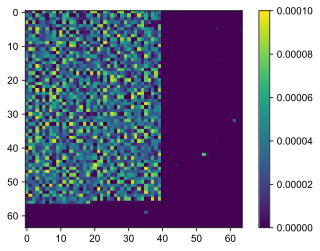

In [16]:
plt.imshow(dpe.read(2))
plt.clim(0, 100e-6)
plt.colorbar()

In [92]:
3.9*2*10

78.0

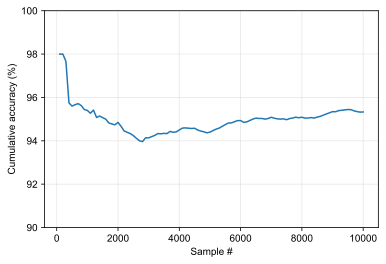

In [91]:
acc_list = np.array(acc_list)

for i in range( len(idx_list) ):
    
#     display.clear_output(wait=True)
    plt.cla()
#     plt.xlim(0, 10000)
    plt.ylim(90, 100)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Sample #')
    plt.ylabel('Cumulative accuracy (%)')
    plt.plot(idx_list[:i+1], acc_list[:i+1]*100)
#     time.sleep(1)
    
#     display.display(fig)
    
    display.clear_output(wait = True)
    plt.pause(0.5)
